# Interpretable Object Detection

## Imports

In [1]:
import torch
import numpy as np
import pandas as pd
import brambox as bb
import lightnet as ln
import interpretability as ip

WARNING    OpenCV is not installed and cannot be used


## Settings and paths

In [2]:
# Settings
bb.logger.setConsoleLevel('ERROR')             # Only show error log messages

# Setting device
device = torch.device('cpu')
if torch.cuda.is_available():
    print('CUDA enabled')
    device = torch.device('cuda')
else:
    print('CUDA not available')
    
# Path variables
network_path = 'cfg/yolo.py'
annos_path = 'data/VOCdevkit/VOC2007/Annotations/'
weights_path = 'weights/yolov2-voc.pt'

# Load annotations
anno = bb.io.load('pandas', 'data/annotations.pkl')
det = bb.io.load('pandas', 'data/detections.pkl')

CUDA enabled


## Picking interesting images

In [3]:
my_class = 'bicycle' # Which class to look at

anno = anno[anno['class_label'] == my_class]
det = det[det['class_label'] == my_class]

pr = bb.stat.pr(det, anno, 0.75)  # IoU threshold of 0.5
ap = bb.stat.ap(pr)

# Find detection threshold with maximal F1
f1 = bb.stat.fscore(pr)
threshold = bb.stat.peak(f1)

# Filter detections based on threshold (computed in previous step from F1-curve)
filtered_det = det[det.confidence >= threshold.confidence].copy()

# Compute TP,FP
tpfp_det = bb.stat.match_det(filtered_det, anno, 0.5)
# match_det() returns detections with a 'tp' and 'fp' column.
print('TP FP:')
display(tpfp_det[tpfp_det['fp']].sort_values(['confidence'], ascending=False))
chosen_images = tpfp_det[tpfp_det['fp']].image.unique()

# Compute FN
fn_anno = bb.stat.match_anno(filtered_det, anno, 0.5)
# match_anno() returns annotations with a 'detection' column that has the index of the matched detection
# We use this to filter unmatched annotations (NaN as index)
fn_anno = fn_anno[fn_anno.detection.isnull()]
print('FN:')
display(fn_anno.head())

TP FP:


,image,class_label,id,x_top_left,y_top_left,width,height,confidence,tp,fp
260260,VOC2007/JPEGImages/006993,bicycle,0,199.793009,69.375368,241.700741,252.270258,0.967542,False,True
135826,VOC2007/JPEGImages/003650,bicycle,0,323.067078,199.635542,155.075220,180.827581,0.732909,False,True


FN:


,image,class_label,id,x_top_left,y_top_left,width,height,occluded,truncated,lost,difficult,ignore,detection,criteria
158,VOC2007/JPEGImages/000111,bicycle,0,333.0,192.0,30.0,19.0,0.0,0.0,False,True,True,NaN,0.0
159,VOC2007/JPEGImages/000111,bicycle,0,302.0,198.0,17.0,12.0,1.0,0.0,False,True,True,NaN,0.0
160,VOC2007/JPEGImages/000111,bicycle,0,242.0,197.0,19.0,14.0,1.0,0.0,False,True,True,NaN,0.0
161,VOC2007/JPEGImages/000111,bicycle,0,218.0,205.0,34.0,12.0,0.0,0.0,False,True,True,NaN,0.0
162,VOC2007/JPEGImages/000111,bicycle,0,174.0,192.0,17.0,18.0,1.0,0.0,False,True,True,NaN,0.0


## Run Backprogation

INFO       Loading weights from file [weights/yolov2-voc.pt]


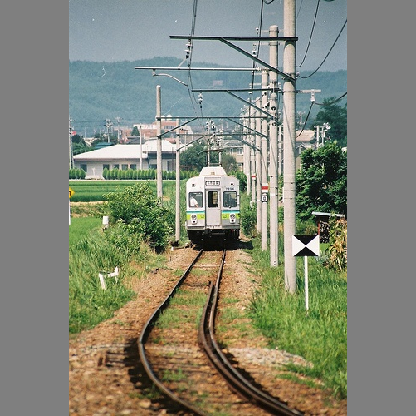

Uit annos: 0 , Berekend: 0
Gekozen: 0


In [4]:
# Variables
anchorbox_threshold = 1.0

gradients_as_arr_list = []
chosen_images = ['VOC2007/JPEGImages/000002']

for image in chosen_images:
    # New path
    new_path = annos_path + image.split('/')[-1] + '.xml'
    
    # Initialize network and load weights
    params = ln.engine.HyperParameters.from_file(network_path)
    params.network.load(weights_path)
    
    # Load annos
    annos = bb.io.load('anno_pascalvoc', new_path, ip.identify)
    
    # Run model
    params, img_tf, annos = ip.detect_new(params, annos, new_path , device)
    display(ip.utils.show_image(img_tf.data.cpu().numpy()[0]))

    # Vanilla backprop
    VBP = ip.backprop.VanillaBackprop(params, device)

    # Generate gradients
    gradients_as_arr = VBP.generate_gradients(params, img_tf, annos, device, anchorbox_threshold)
    for gradient in gradients_as_arr:
        gradients_as_arr_list.append(gradient)

## Show images on screen

max: 0.23949085 , min: -0.401842
1.0 0.0


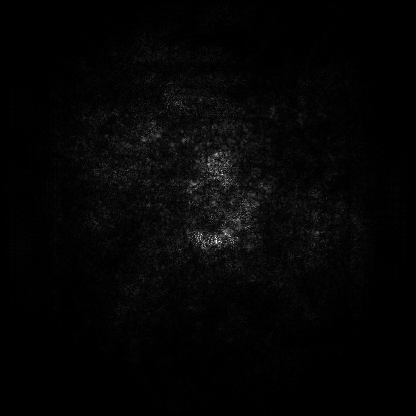

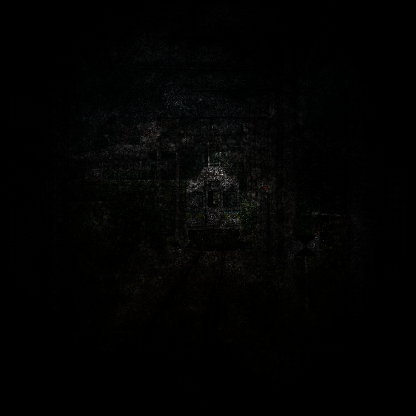

In [5]:
# Normalize to grayscale and show images
gradients_list = ip.utils.normalize(gradients_as_arr_list, True)
for gradient in gradients_list:
    display(ip.utils.show_image(gradient), ip.utils.show_image(gradient * img_tf.data.cpu().numpy()[0]))